In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from botorch.utils import standardize
import warnings
# Ignore the warning
warnings.filterwarnings('ignore')


Import the dataset, explore and clean up.

In [2]:
data = pd.read_csv('Battery_RUL.csv')
# 2. Check for blanks and NAs
data.head(10)

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992000,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993000,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016000,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992000,53213.54,56699.65,1107
5,7.0,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106
6,8.0,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105
7,9.0,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104
8,10.0,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103
9,11.0,435251.49,263086.078000,4.267,3.086,269.984000,443700.02,443700.02,1102


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


there is no missing data or unexpected data types.

Checking data for outliers

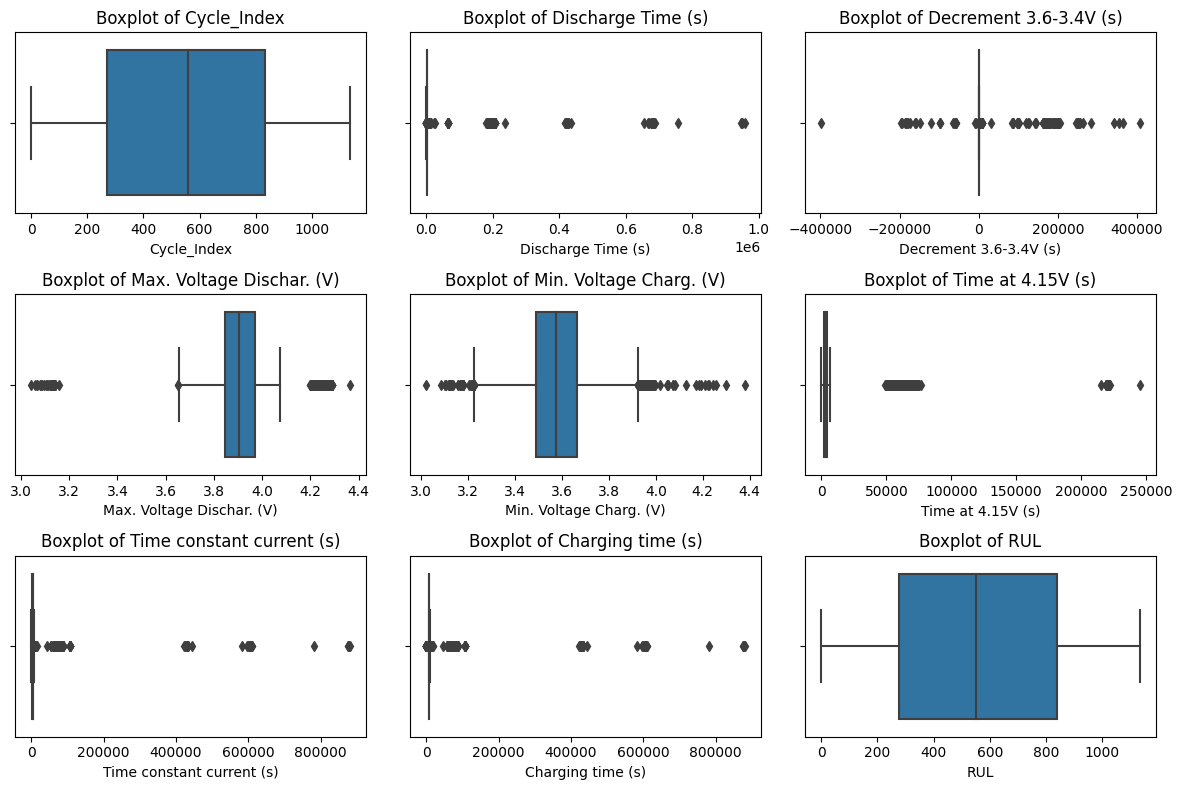

In [4]:
# Calculate the number of columns and rows based on the number of features
num_features = len(data.columns)
num_cols = 3  # Adjust the number of columns as per your preference
num_rows = (num_features + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(data.columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(f"Boxplot of {column}")

# Remove empty subplots, if any
if len(data.columns) < num_rows * num_cols:
    for j in range(len(data.columns), num_rows * num_cols):
        fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

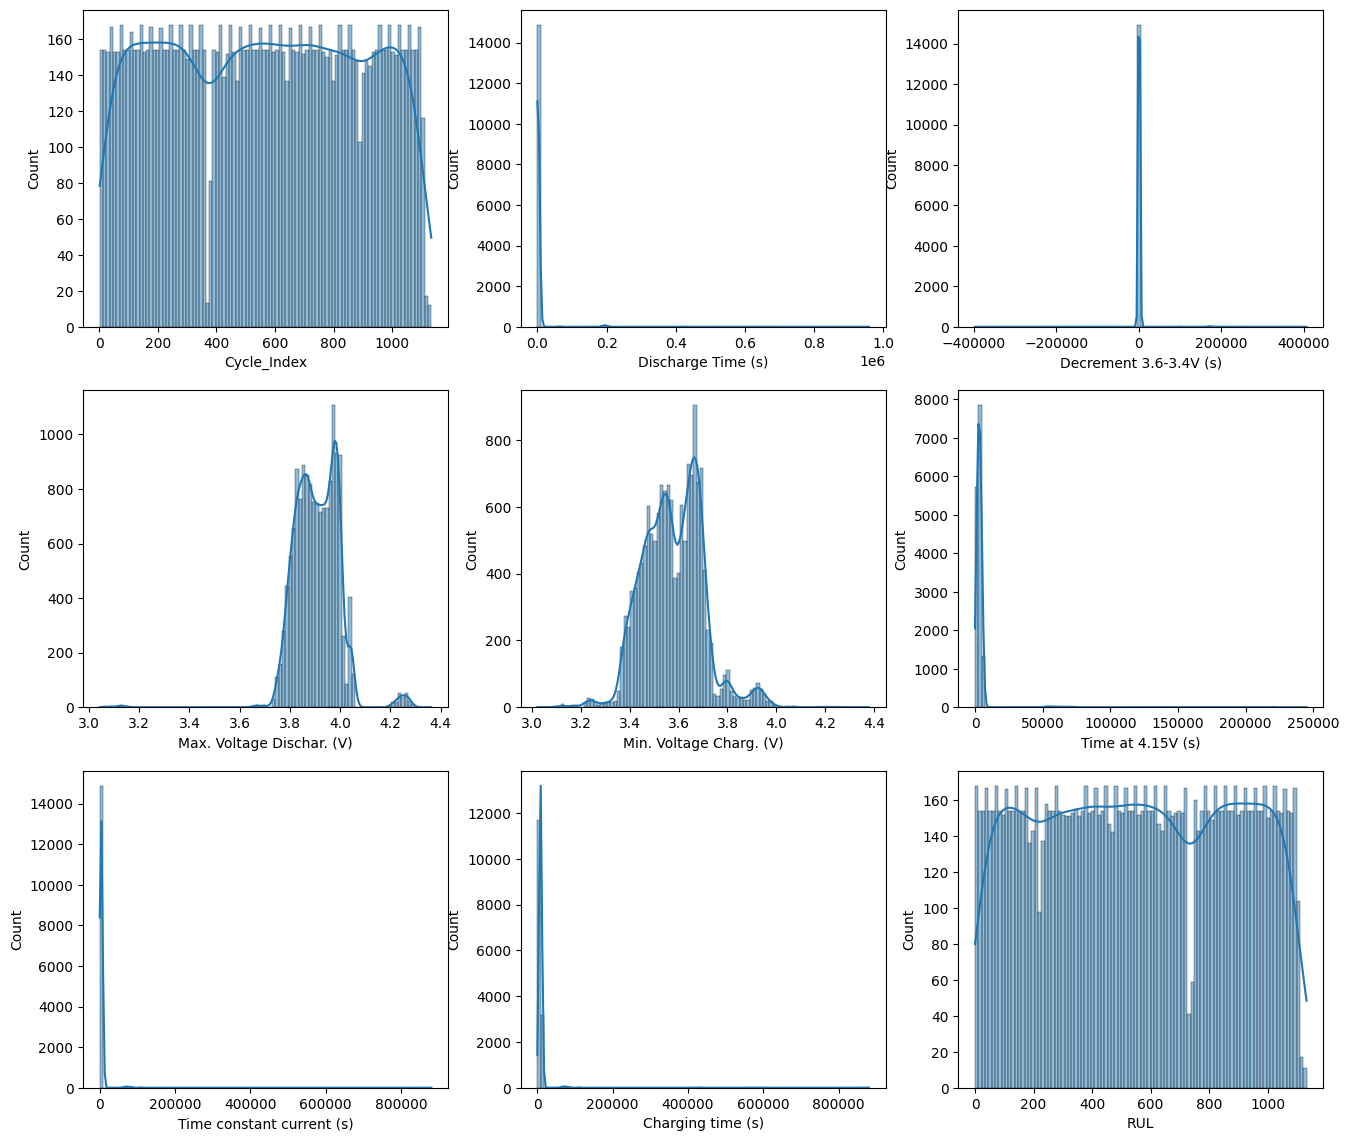

In [5]:
plt.figure(figsize=(16,14))
column_labels = data.columns.tolist()
for i,col in enumerate(column_labels):
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=data, bins=100, kde=True)

plt.show()

Box plot and histogram plot show that the columns Discharge Time, Decrement 3.6-3.4v, Time at 4.15V, time constant and charging time have outliers.

Checking for covariances between variables

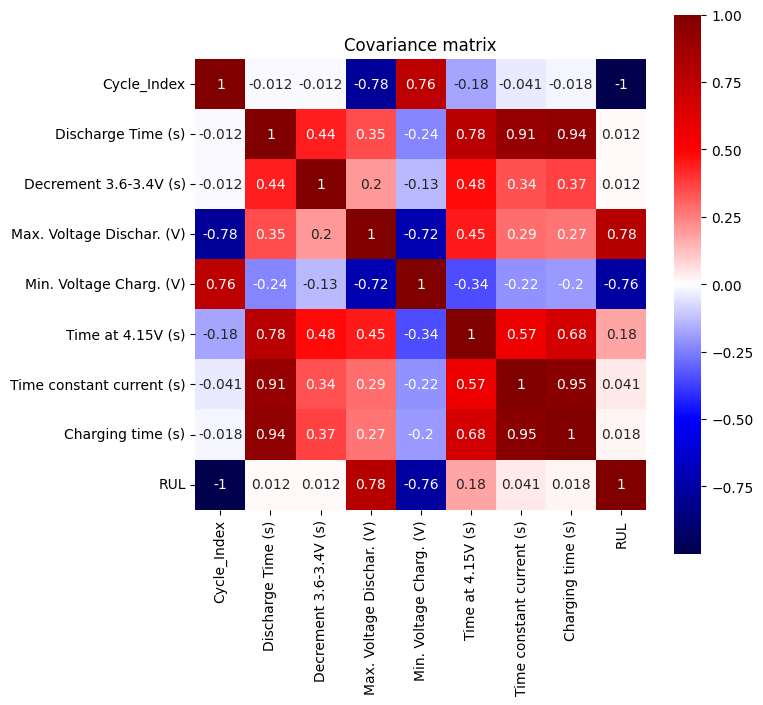

In [6]:
plt.figure(figsize=(16, 7))
cmap = 'seismic'

plt.subplot(1, 2, 1)
plt.title('Covariance matrix')
sns.heatmap(data.corr(), cmap=cmap, annot=True, square=True)


plt.show()

Prior to data cleanup, the covariance matrix shows that following variables have strong relationships with the output - Cycle index, Max voltage discharge, min voltage charge

Removing outliers

In [7]:
def remove_outliers(data, threshold):
    """
    Remove outliers from each column of a DataFrame using the IQR method and plot histograms for the cleaned data.
    
    Args:
        data (pandas.DataFrame): The input DataFrame.
        threshold (float): The outlier threshold in terms of IQR. Default is 1.5.
    
    Returns:
        pandas.DataFrame: The DataFrame with outliers removed.
    """
    # Create a copy of the input DataFrame
    cleaned_data = data.copy()
    
    # Iterate over each column
    for column in cleaned_data.columns:
        # Calculate quartiles and IQR
        Q1 = cleaned_data[column].quantile(0.25)
        Q3 = cleaned_data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Remove outliers
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)]
    
    # Plot histograms for cleaned data
    plt.figure(figsize=(16,14))
    column_labels = cleaned_data.columns.tolist()
    for i, col in enumerate(column_labels):
        plt.subplot(3, 3, i + 1)
        sns.histplot(x=col, data=cleaned_data, bins=100, kde=True)
    
    plt.show()
    
    return cleaned_data

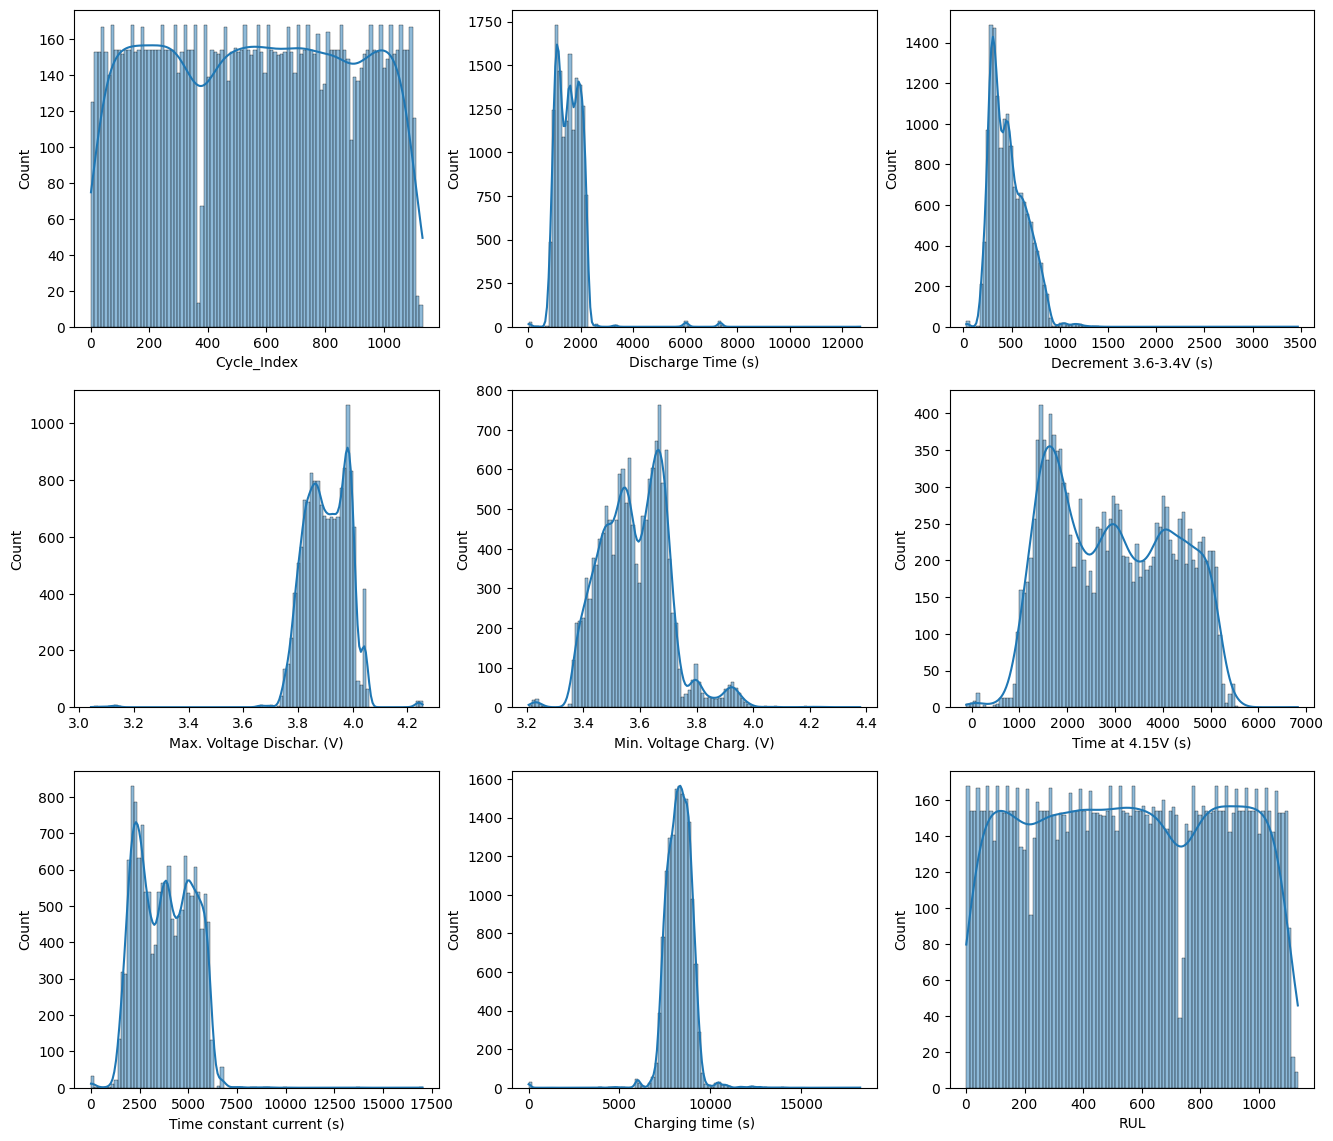

In [8]:
data.info
data = remove_outliers(data,15)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14878 entries, 0 to 15062
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                14878 non-null  float64
 1   Discharge Time (s)         14878 non-null  float64
 2   Decrement 3.6-3.4V (s)     14878 non-null  float64
 3   Max. Voltage Dischar. (V)  14878 non-null  float64
 4   Min. Voltage Charg. (V)    14878 non-null  float64
 5   Time at 4.15V (s)          14878 non-null  float64
 6   Time constant current (s)  14878 non-null  float64
 7   Charging time (s)          14878 non-null  float64
 8   RUL                        14878 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.6 MB


In [10]:
print((1-14878/15064)*100,'% of the data has been removed')

1.234731810939993 % of the data has been removed


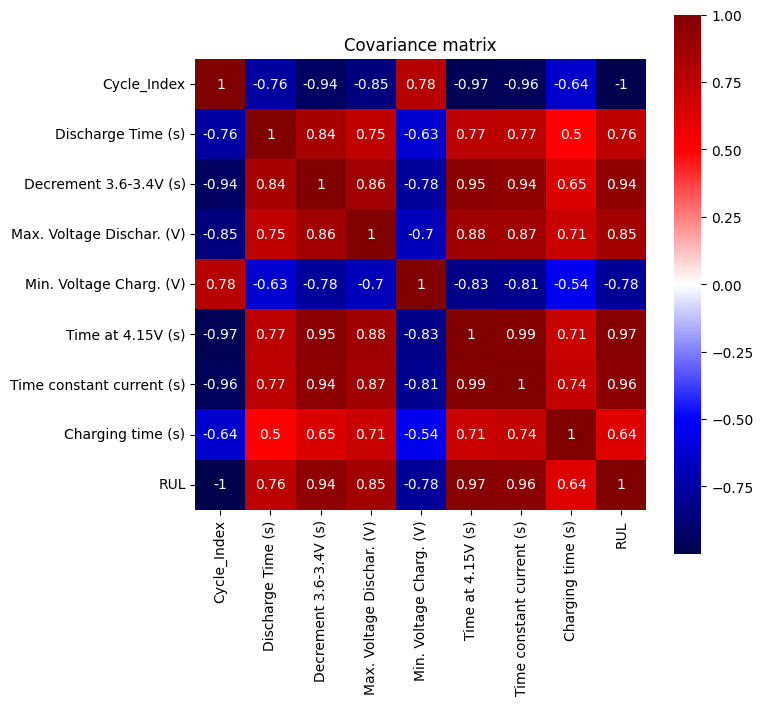

In [11]:
plt.figure(figsize=(16, 7))
cmap = 'seismic'

plt.subplot(1, 2, 1)
plt.title('Covariance matrix')
sns.heatmap(data.corr(), cmap=cmap, annot=True, square=True)


plt.show()

 **Data preprocessing and preparation **
 
This code snippet performs the following tasks:

It splits the data into features (X) and the target variable (y), where the 'RUL' and 'Cycle_Index' columns are dropped from X, and 'RUL' is assigned to y.
The feature data (X) is normalized using the MinMaxScaler, which scales the values between 0 and 1.
The normalized data is then split into training and testing sets, with 80% of the data used for training and 20% for testing. The random_state parameter ensures reproducibility of the split.
It checks if a GPU is available and sets the device accordingly (GPU if available, otherwise CPU).
The training and testing data are converted into Torch tensors and moved to the specified device (GPU or CPU).
The target values (y_train_tensor and y_test_tensor) are reshaped to have two dimensions, which is necessary for further processing.
The target values are standardized using the standardize function, which scales the values to have zero mean and unit variance. The standardized values are then reshaped to have an explicit output dimension.
These steps are part of the data preprocessing and preparation phase for training a machine learning model, specifically for Bayesian optimization using a Random Forest Regressor.

In [12]:

# 4. Split data into features (X) and target variable (y)
X = data.drop(['RUL','Cycle_Index'], axis=1)
y = data['RUL']

# 5. Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 6. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Is CUDA supported by this system? \"{torch.cuda.is_available()}\"")

# Convert the data to torch tensors and move to GPU
X_train_tensor = torch.from_numpy(X_train).double().to(device)
X_test_tensor = torch.from_numpy(X_test).double().to(device)
y_train_tensor = torch.from_numpy(y_train.values).double().to(device)  # Convert Series to NumPy array and float type
y_test_tensor = torch.from_numpy(y_test.values).double().to(device)  # Convert Series to NumPy array and float type
# Reshape y_train_tensor to have two dimensions
y_train_tensor = y_train_tensor.unsqueeze(-1)
y_test_tensor = y_test_tensor.unsqueeze(-1)

# Standardize the target values
y_train_standardized = standardize(y_train_tensor).unsqueeze(-1)  # Add explicit output dimension



Is CUDA supported by this system? "True"


**Perform a random search to find the initial hyperparameters that maximize the performance (minimize the MSE) of a RandomForestRegressor model.**

We need some initial data to use as a starting point for our baysian optimisation. The code below uses random search to generate intial point. The following steps are taken. It defines the bounds for the hyperparameters using a torch tensor. The bounds specify the minimum and maximum values for each hyperparameter.
The generate_initial_data function generates initial random hyperparameters within the specified bounds and evaluates the objective function to calculate the corresponding mean squared error (MSE).
The objective function takes a set of hyperparameters as input and creates a RandomForestRegressor model with those hyperparameters. It fits the model on the training data, predicts on the test data, and calculates the MSE between the predicted and actual values.
The objective function returns the negative MSE as the objective value, as it is to be maximized.
The random search loop iterates over a predefined number of iterations and selects random hyperparameters within the bounds. It evaluates the objective function for each set of hyperparameters and keeps track of the best hyperparameters and the corresponding MSE.


In [23]:
#Random seach of the hyperparameters
bounds = torch.tensor([[20.0, 1.0, 2.0, 1.0], [1000.0, 20.0, 20.0, 20.0]])

def generate_initial_data(n, objective_function):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    X_HyperParams = []
    y_outputMSE = []
    
    for _ in range(n):
        # Generate random hyperparameters within the specified bounds
        params = torch.tensor(np.random.uniform(bounds[0], bounds[1])).to(device)
        
        # Evaluate the objective function to get the corresponding MSE
        mse = objective_function(params)

        # Store the hyperparameters and MSE
        X_HyperParams.append(params)
        y_outputMSE.append([mse])  # Wrap mse in a list to create a 2D shape

    X_HyperParams = torch.stack(X_HyperParams).float()  # Convert X_HyperParams to float32
    y_outputMSE = torch.tensor(y_outputMSE).float()  # Convert y_outputMSE to float32
    #print('X_HyperParams', X_HyperParams)
    #print('y_outputMSE', y_outputMSE)
    return X_HyperParams, y_outputMSE

# Define the objective function to be maximized (maximum value)
def objective_function(params):
    # Extract the hyperparameters
    #print(params[0])
    n_estimators = int(params[0])
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    # Create a RandomForestRegressor model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )

    # Move the data to the CPU before fitting the model
    X_train_cpu = X_train_tensor.cpu()
    y_train_cpu = y_train_tensor.cpu()

    # Reshape y_train_cpu to 1D array
    y_train_cpu = y_train_cpu.ravel()

    # Fit the model on the training data
    model.fit(X_train_cpu, y_train_cpu)

    # Move the test data to the CPU before making predictions
    X_test_cpu = X_test_tensor.cpu()

    # Predict on the test data
    y_pred = model.predict(X_test_cpu)
    y_pred_tensor = torch.from_numpy(y_pred).float().to(device).unsqueeze(-1)

    # Move y_test_tensor and y_pred_tensor to CPU
    y_test_cpu = y_test_tensor.cpu()
    y_pred_cpu = y_pred_tensor.cpu()

    # Calculate the mean squared error
    mse = mean_squared_error(y_test_cpu, y_pred_cpu)

    # Return the negative mean squared error as the objective value
    return -mse


In [24]:
n = 10
X_HyperParams_randSearch, y_outputMSE_randSearch = generate_initial_data(n, objective_function)


In [25]:
X_HyperParams_randSearch


tensor([[294.5520,  13.3055,   4.6130,   6.4413],
        [876.3254,  15.0653,   4.5700,   6.1109],
        [434.5735,   5.5243,  10.1010,   9.3093],
        [682.2012,  11.8582,  13.3142,   9.7847],
        [803.2044,   3.8779,   3.3063,  19.9291],
        [529.7143,   9.9755,  15.3754,   8.9499],
        [245.2520,   7.8204,   2.9348,   9.8725],
        [207.1972,  19.9220,  16.0366,   1.8288],
        [269.2766,  13.6540,   3.5737,   6.6050],
        [401.4413,  13.8324,  14.7952,  15.9479]], device='cuda:0')

In [16]:
bounds.shape

torch.Size([2, 4])

In [26]:
y_outputMSE_randSearch

tensor([[-1101.4379],
        [-1063.3666],
        [-3045.6863],
        [-1351.1760],
        [-6658.1387],
        [-1470.8407],
        [-1899.5953],
        [ -987.2950],
        [-1102.5170],
        [-1713.9630]])

**Normalize the input hyperparameters obtained from the random search step, preparing them for Bayesian optimization.**

For our baysian optimisation, we need to normalise the hyperparameters before they are used for calculating the next candindates. Once the candidates are calculated, we need to denormalise them so that we can evaluate our objective function. The normalize_data function takes input data and bounds as arguments. It normalizes the input data based on the specified bounds. The minimum and maximum values in the bounds are used to scale the data to the range [0, 1]. The normalized data is returned.
The denormalize_data function takes normalized data and bounds as arguments. It denormalizes the normalized data based on the specified bounds. The data is rescaled back to the original range using the minimum and maximum values from the bounds. The denormalized data is returned.
X_bayes is assigned the normalized version of X_HyperParams_randSearch, where X_HyperParams_randSearch represents the initial hyperparameters generated through random search. The normalize_data function is used to perform the normalization.
y_bayes is assigned y_outputMSE_randSearch converted to torch.float64. y_outputMSE_randSearch contains the corresponding mean squared errors (MSEs) for the initial hyperparameters obtained from random search.

In [27]:
#initial hyperparameters that will be used for our baysian optimisation
def normalize_data(data, bounds):
    """Normalize the input data based on specified bounds."""
    min_vals = bounds[0, :].to(data.device)
    max_vals = bounds[1, :].to(data.device)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

def denormalize_data(normalized_data, bounds):
    """Denormalize the input data based on specified bounds."""
    min_vals = bounds[0, :]#.to(normalized_data.device)
    max_vals = bounds[1, :]#.to(normalized_data.device)
    denormalized_data = normalized_data * (max_vals - min_vals) + min_vals
    return denormalized_data

X_bayes=normalize_data(X_HyperParams_randSearch, bounds)
y_bayes=y_outputMSE_randSearch.to(torch.float64)

**Automate the process of hyperparameter optimization using Bayesian optimization to find the best configuration for a RandomForestRegressor model.**

This code snippet performs Bayesian optimization to find the best hyperparameters for a RandomForestRegressor model. Here's a summary of what it does:

It imports necessary libraries for the optimization process, including torch, pandas, numpy, and scikit-learn.
The data is loaded from a CSV file and split into features (X) and the target variable (y).
The data is normalized using MinMaxScaler and split into training and testing sets.
The device is set to GPU if available, and the data is converted to torch tensors and moved to the GPU.
The objective function is defined, which calculates the negative mean squared error (MSE) for a given set of hyperparameters. It trains a RandomForestRegressor model using the hyperparameters on the training data and predicts the target variable for the test data. The MSE is calculated and returned as the negative objective value.
The bounds for the hyperparameters are defined.
Bayesian optimization is performed for a specified number of iterations. It uses the SingleTaskGP model from botorch to model the objective function and the Upper Confidence Bound (UCB) acquisition function to select the next candidate hyperparameters.
The best hyperparameters and corresponding MSE are updated based on the candidate hyperparameters with the highest MSE.
Finally, the best hyperparameters are used to create the final RandomForestRegressor model, which is trained on the entire training data. The model predicts the target variable for the test data, and the mean squared error is calculated and printed.

In [42]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.utils import standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

from botorch.fit import fit_gpytorch_model
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition import qProbabilityOfImprovement


# Load and preprocess the data
data = pd.read_csv('Battery_RUL.csv')
# 4. Split data into features (X) and target variable (y)
X = data.drop(['RUL', 'Cycle_Index'], axis=1)
y = data['RUL']

# 5. Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 6. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Is CUDA supported by this system? \"{torch.cuda.is_available()}\"")

# Convert the data to torch tensors and move to GPU
X_train_tensor = torch.from_numpy(X_train).double().to(device)
X_test_tensor = torch.from_numpy(X_test).double().to(device)
y_train_tensor = torch.from_numpy(y_train.values).double().to(device)  # Convert Series to NumPy array and float type
y_test_tensor = torch.from_numpy(y_test.values).double().to(device)  # Convert Series to NumPy array and float type


# Reshape y_train_tensor to have two dimensions
y_train_tensor = y_train_tensor.unsqueeze(-1)
y_test_tensor = y_test_tensor.unsqueeze(-1)

# Standardize the target values
y_train_standardized = standardize(y_train_tensor).unsqueeze(-1)  # Add explicit output dimension

# Define the bounds for the hyperparameters
bounds = torch.tensor([[20.0, 1.0, 2.0, 1.0], [1000.0, 20.0, 20.0, 20.0]])#.to(device)  # Use float data type
#bounds = [100.0, 1.0, 2.0, 1.0], [1000.0, 10.0, 20.0, 10.0]
norm_bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]]).to(device)  # Use float data type


# Define the objective function to be minimized (negative mean squared error)
def objective_function(params):
    numpy_bounds=bounds.numpy()
    params=denormalize_data(params, numpy_bounds)
    # Extract the hyperparameters
    #n_estimators, max_depth, min_samples_split, min_samples_leaf = params
    n_estimators = int(params[0,0])
    max_depth = params[0,1]
    min_samples_split = params[0,2]
    min_samples_leaf = params[0,3]
    # Create a RandomForestRegressor model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )

    # Move the data to the CPU before fitting the model
    X_train_cpu = X_train_tensor.cpu()
    y_train_cpu = y_train_tensor.cpu()

    # Reshape y_train_cpu to 1D array
    y_train_cpu = y_train_cpu.ravel()

    # Fit the model on the training data
    model.fit(X_train_cpu, y_train_cpu)

    # Move the test data to the CPU before making predictions
    X_test_cpu = X_test_tensor.cpu()

    # Predict on the test data
    y_pred = model.predict(X_test_cpu)
    y_pred_tensor = torch.from_numpy(y_pred).float().to(device).unsqueeze(-1)

    # Move y_test_tensor and y_pred_tensor to CPU
    y_test_cpu = y_test_tensor.cpu()
    y_pred_cpu = y_pred_tensor.cpu()

    # Calculate the mean squared error
    mse = mean_squared_error(y_test_cpu, y_pred_cpu)

    # Return the negative mean squared error as the objective value
    return -mse,y_pred_cpu


# Perform Bayesian optimization
best_mse = max(y_bayes)
num_iterations = 2  # Set the desired number of iterations
for i in range(num_iterations):
    X_bayes = X_bayes.to(torch.float64)
    
    likelihood = GaussianLikelihood()
    model = SingleTaskGP(X_bayes, y_bayes, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    UCB = UpperConfidenceBound(model=model, beta=1.0)
    #UCB = qUpperConfidenceBound(model=model, beta=0.1)  # set the beta parameter as desired
    #EI = qExpectedImprovement(model=model, best_f=best_mse)
    #PI = qProbabilityOfImprovement(model=model, best_f=best_mse)
 
    candidates = optimize_acqf(
        acq_function=UCB,
        bounds=norm_bounds,
        q=1,
        num_restarts=1000,
        raw_samples=5000,
        options={"batch_limit": 100, "maxiter": 2000},
        
    )
 
    candidate = candidates[0].detach().cpu().numpy()
    curr_mse,y_pred_cpu = objective_function(candidate)
    candidate_tensor = torch.tensor(candidate, device=X_bayes.device)
    
    
    X_bayes = torch.cat([X_bayes, candidate_tensor], 0)
    curr_mse_tensor = torch.tensor(curr_mse).unsqueeze(0)
    y_bayes = torch.cat([y_bayes, curr_mse_tensor.unsqueeze(1)], 0)

    if curr_mse > best_mse:
        best_mse = curr_mse
        best_params = candidate
    
    print("Iteration:",i+1,"/",num_iterations," candidate:",candidate[0],' MSE:', curr_mse," best MSE:",best_mse)

# Get the best hyperparameters and corresponding minimum mean squared error
best_score = -best_mse
#print("\nBest Hyperparameters:")
#print(best_params)
print("Best Negative MSE Score:", best_score)
print("Best Parameters:",best_params)


curr_mse,y_pred_cpu = objective_function(best_params)

# Create the final RandomForestRegressor model with the best hyperparameters
#best_model = RandomForestRegressor(**dict(zip(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'], best_params)), random_state=42)
#best_model.fit(X_train, y_train)

# Predict on the test data using the best model
#y_pred = best_model.predict(X_test_tensor)
mse = mean_squared_error(y_test, y_pred_cpu)
print("Final Mean Squared Error:", mse)


Is CUDA supported by this system? "True"
Iteration: 1 / 2  candidate: [0.        0.7403533 0.        0.       ]  MSE: -772.5575937109166  best MSE: tensor([-759.6172], dtype=torch.float64)
Iteration: 2 / 2  candidate: [0.        0.7403467 0.        0.       ]  MSE: -772.5575937109166  best MSE: tensor([-759.6172], dtype=torch.float64)
Best Negative MSE Score: tensor([759.6172], dtype=torch.float64)
Best Parameters: [[1.2033076e-02 1.0000000e+00 9.9876430e-05 1.2365332e-02]]
Final Mean Squared Error: 759.6172281560299


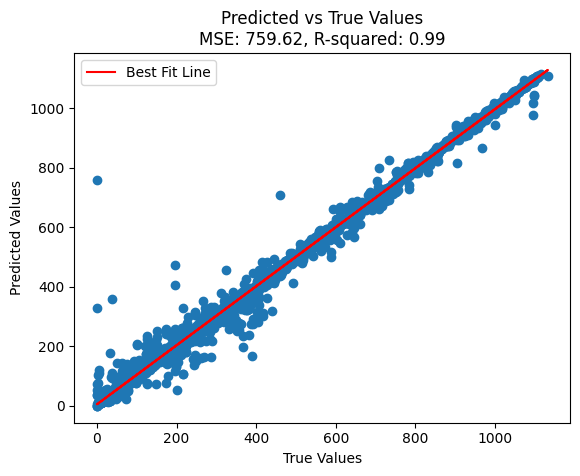

In [46]:

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_cpu)
r2 = r2_score(y_test, y_pred_cpu)

# Fit a linear regression line
slope, intercept = np.polyfit(y_test, y_pred_cpu, deg=1)
line = slope * y_test + intercept

plt.scatter(y_test, y_pred_cpu)
plt.plot(y_test, line, color='red', label='Best Fit Line')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values\nMSE: {:.2f}, R-squared: {:.2f}".format(mse, r2))
plt.legend()
plt.show()


**Visualise baysian optimisation iteration results**

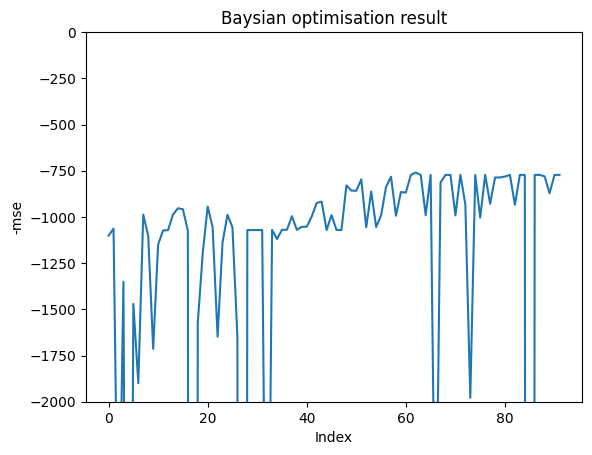

In [44]:
import matplotlib.pyplot as plt
import torch

# Define the tensor


# Convert the tensor to a numpy array
tensor_array = y_bayes.numpy()

# Create x-axis values (assumed to be the index of each tensor element)
x_values = range(len(tensor_array))

# Plot the tensor values
plt.plot(x_values, tensor_array)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('-mse')
plt.title('Baysian optimisation result')
plt.ylim([-2000,0])
# Display the plot
plt.show()

**Perform a grid search to find the hyperparameters that yield the best performance (highest MSE).**

In [36]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def generate_initial_data(n, objective_function):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bounds = torch.tensor([[100.0, 1.0, 2.0, 1.0], [1000.0, 10.0, 20.0, 10.0]]).to(device) 
    
    X_HyperParams = []
    y_outputMSE = []

    n_points_per_dim = int(np.ceil(np.power(n, 1/4)))  # Compute the number of points per dimension
    x=0
    # Generate grid of hyperparameters
    for n_estimator in torch.linspace(bounds[0, 0], bounds[1, 0], n_points_per_dim):
        for max_depth in torch.linspace(bounds[0, 1], bounds[1, 1], n_points_per_dim):
            for min_samples_split in torch.linspace(bounds[0, 2], bounds[1, 2], n_points_per_dim):
                for min_samples_leaf in torch.linspace(bounds[0, 3], bounds[1, 3], n_points_per_dim):
                    params = torch.tensor([n_estimator, max_depth, min_samples_split, min_samples_leaf]).to(device)
                    
                    mse = objective_function(params)

                    X_HyperParams.append(params)
                    y_outputMSE.append([mse])
                    x=x+1
                    print(x,params,mse,max(y_outputMSE))

    X_HyperParams = torch.stack(X_HyperParams).float().to(device)  # Convert X_HyperParams to float32 and move to GPU
    y_outputMSE = torch.tensor(y_outputMSE).float().to(device)  # Convert y_outputMSE to float32 and move to GPU

    return X_HyperParams, y_outputMSE


# Define the objective function to be maximized (maximum value)
def objective_function(params):
    device = params.device
    # Extract the hyperparameters
    n_estimators = int(params[0])
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]

    # Create a RandomForestRegressor model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )

    # Move the data to the CPU before fitting the model
    X_train_cpu = X_train_tensor.cpu()
    y_train_cpu = y_train_tensor.cpu()

    # Reshape y_train_cpu to 1D array
    y_train_cpu = y_train_cpu.ravel()

    # Fit the model on the training data
    model.fit(X_train_cpu, y_train_cpu)

    # Move the test data to the CPU before making predictions
    X_test_cpu = X_test_tensor.cpu()

    # Predict on the test data
    y_pred = model.predict(X_test_cpu)
    y_pred_tensor = torch.from_numpy(y_pred).float().unsqueeze(-1)

    # Move y_test_tensor and y_pred_tensor to the CPU
    y_test_cpu = y_test_tensor.cpu()
    y_pred_cpu = y_pred_tensor.cpu()

    # Calculate the mean squared error
    mse = mean_squared_error(y_test_cpu, y_pred_cpu)

    # Return the negative mean squared error as the objective value
    return -mse


n = 40
X_HyperParams_gridSearch, y_outputMSE_gridSearch = generate_initial_data(n, objective_function)

# Move X_HyperParams_gridSearch and y_outputMSE_gridSearch to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_HyperParams_gridSearch = X_HyperParams_gridSearch.to(device)
y_outputMSE_gridSearch = y_outputMSE_gridSearch.to(device)

# Define variables to track the best MSE and its corresponding hyperparameters
best_mse = float('-inf')
best_hyperparams = None

# Iterate over the candidates
for i, params in enumerate(X_HyperParams_gridSearch):
    mse = y_outputMSE_gridSearch[i].item()
    candidates = params.tolist()

    # Print the iteration number, candidates, MSE, and the best MSE so far
    print(f"Iteration: {i+1} | Candidates: {candidates} | MSE: {mse:.4f} | Best MSE: {best_mse:.4f}")

    # Update the best MSE and hyperparameters if a new best is found
    if mse > best_mse:
        best_mse = mse
        best_hyperparams = candidates

print("\nBest hyperparameters:")
print(best_hyperparams)
print("Best MSE:")
print(best_mse)


1 tensor([100.,   1.,   2.,   1.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
2 tensor([100.0000,   1.0000,   2.0000,   5.5000], device='cuda:0') -26375.039555294825 [-26375.039555294825]
3 tensor([100.,   1.,   2.,  10.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
4 tensor([100.,   1.,  11.,   1.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
5 tensor([100.0000,   1.0000,  11.0000,   5.5000], device='cuda:0') -26375.039555294825 [-26375.039555294825]
6 tensor([100.,   1.,  11.,  10.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
7 tensor([100.,   1.,  20.,   1.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
8 tensor([100.0000,   1.0000,  20.0000,   5.5000], device='cuda:0') -26375.039555294825 [-26375.039555294825]
9 tensor([100.,   1.,  20.,  10.], device='cuda:0') -26375.039555294825 [-26375.039555294825]
10 tensor([100.0000,   5.5000,   2.0000,   1.0000], device='cuda:0') -2979.4016670581623 [-2979.4016670581

80 tensor([1000.0000,   10.0000,   20.0000,    5.5000], device='cuda:0') -1325.5974081485508 [-1026.8953898110044]
81 tensor([1000.,   10.,   20.,   10.], device='cuda:0') -1486.6812237705255 [-1026.8953898110044]
Iteration: 1 | Candidates: [100.0, 1.0, 2.0, 1.0] | MSE: -26375.0391 | Best MSE: -inf
Iteration: 2 | Candidates: [100.0, 1.0, 2.0, 5.5] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 3 | Candidates: [100.0, 1.0, 2.0, 10.0] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 4 | Candidates: [100.0, 1.0, 11.0, 1.0] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 5 | Candidates: [100.0, 1.0, 11.0, 5.5] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 6 | Candidates: [100.0, 1.0, 11.0, 10.0] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 7 | Candidates: [100.0, 1.0, 20.0, 1.0] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 8 | Candidates: [100.0, 1.0, 20.0, 5.5] | MSE: -26375.0391 | Best MSE: -26375.0391
Iteration: 9 | Candidates: [100.0, 1.0, 20

**Plot to compare performance of gridsearch and Bayesian optimisation**

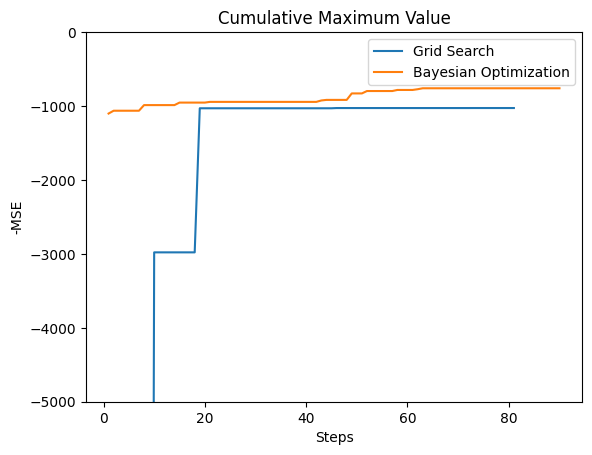

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a Torch tensor called 'tensor_data'
gridSearch_data = y_outputMSE_gridSearch.cpu()
randSearch_data = y_outputMSE_randSearch
bayesOpt_data = y_bayes

# Convert Torch tensor to NumPy array
gridSearch_data = gridSearch_data.numpy()
randSearch_data = randSearch_data.numpy()
bayesOpt_data = bayesOpt_data.numpy()

# Calculate cumulative maximum values along the desired axis
gridSearch_cumulative_max = np.maximum.accumulate(gridSearch_data)
randSearch_cumulative_max = np.maximum.accumulate(randSearch_data)
bayesOpt_cumulative_max = np.maximum.accumulate(bayesOpt_data)

# Create x-axis values (assuming 1D tensor)
x1 = np.arange(1, len(gridSearch_data) + 1)
x2 = np.arange(1, len(randSearch_data) + 1)
x3 = np.arange(1, len(bayesOpt_data) + 1)

# Plot the cumulative maximum values
plt.plot(x1, gridSearch_cumulative_max, label='Grid Search')
#plt.plot(x2, randSearch_cumulative_max, label='Random Search')
plt.plot(x3, bayesOpt_cumulative_max, label='Bayesian Optimization')
plt.xlabel('Steps')
plt.ylabel('-MSE')
plt.title('Cumulative Maximum Value')
plt.ylim([-5000,0])  
#plt.yscale('log')  
plt.legend()
plt.show()